In [72]:
import os
from pathlib import Path

import numpy as np
import librosa as lb
# import soundfile as sf
# import pyaudio
import sounddevice as sd

import torch
import torch.nn as nn
import torch.nn.functional as F

import sklearn
import sklearn.decomposition

import plotly
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

from models.VAE_1 import VAE_1
from models.VAE_2 import VAE_2
from models.VAE_3 import VAE_3

from utils.prepare_data import pad_or_trim

from utils.config import load_config

import scipy

In [2]:
# def play_wave(wave, sr):
#     # initialize PyAudio
#     p = pyaudio.PyAudio()

#     # open a stream
#     stream = p.open(format=pyaudio.paFloat32,
#                     channels=1,
#                     rate=sr,
#                     output=True)

#     # play audio
#     stream.write(wave.tobytes())

#     # stop stream and terminate PyAudio
#     stream.stop_stream()
#     stream.close()
#     p.terminate()

In [38]:
def load_wave(path):
    sample, sr = lb.load(path)
    return sample, sr

def load_random_wave(sample_type, path_to_samples = r"C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music\data\drums-one_shots"):
    # load random wave

    # if sample_type == 'random':
    #     sample_type = np.random.choice(os.listdir(path_to_samples))

    path = os.path.join(path_to_samples, sample_type, f'{sample_type}_samples')

    sample_name = np.random.choice(os.listdir(path))
    sample, sr = load_wave(os.path.join(path, sample_name))
    return sample, sr

def load_all_waves(sample_types: list, path_to_samples = r"C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music\data\drums-one_shots", return_sample_groups = False):
    waves = []
    for sample_type in sample_types:
        path = os.path.join(path_to_samples, sample_type, f'{sample_type}_samples')
        for sample_name in os.listdir(path):
            sample, sr = load_wave(os.path.join(path, sample_name))
            if return_sample_groups:
                waves.append((sample, sr, sample_type))
            else:
                waves.append((sample, sr))
    return waves

def convert_to_mfcc(wave, sr):
    mfcc = lb.feature.mfcc(y=wave, sr=sr, **MFCC_KWARGS)
    return mfcc

def convert_to_wave(mfcc, sr):
    return lb.feature.inverse.mfcc_to_audio(mfcc=mfcc, sr=sr, **INVERSE_MFCC_KWARGS)

In [27]:
def sample_from_latent_space(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

def fuse_sampled_samples(samples, weights = None):
    if weights is None:
        weights = np.ones(len(samples)) / len(samples)
    return np.average(samples, axis=0, weights=weights).astype(np.float32)

In [59]:
import sys
sys.path.append(r'C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music')
# sys.path.append(r'/storage/praha1/home/buciak/bachelors_thesis/bachelor_thesis-Electronic_music')


model_dir_path = Path(r'C:\Users\llama\Desktop\cuni\bakalarka\Bachelor_thesis-Electronic_music\trained_models\VAE_3_grid_search_1\VAE_3__noise=False__kl=0.1')
# model_dir_path = Path(r'/storage/praha1/home/buciak/bachelors_thesis/test_results/test_no_noise')

model_name = os.path.basename(model_dir_path)
config = load_config(model_dir_path / f'{model_name}_config.json')

model = VAE_3(config.latent_dim)
model.load_state_dict(torch.load(model_dir_path / f'model_{model_name}.pkl', map_location=torch.device('cpu')))

LENGTH = config.pad_or_trim_length

In [60]:
MFCC_KWARGS = config.mfcc_kwargs

INVERSE_MFCC_KWARGS = {
    'n_mels': MFCC_KWARGS['n_mels'],
    'dct_type': MFCC_KWARGS['dct_type'],
    'norm': MFCC_KWARGS['norm'],
    'lifter': MFCC_KWARGS['lifter'],
    'n_fft': MFCC_KWARGS['n_fft'],
    'hop_length': MFCC_KWARGS['hop_length'],
    'win_length': MFCC_KWARGS['win_length'],
    'window':  MFCC_KWARGS['window'],
    'center': MFCC_KWARGS['center'],
    'pad_mode': MFCC_KWARGS['pad_mode'],
    'power': MFCC_KWARGS['power'],


    'ref': 1.0,
    'n_iter': 32,
    'length': None,
    'dtype': np.float32
}


### sampling random sounds from latent space

In [35]:
# for i in range(20):
#     wave, sr = load_random_wave('other')
#     sd.play(wave, sr); sd.wait()

# print('done')

# for i in range(20):
#     wave, sr = load_random_wave('other')
#     sd.play(wave, sr); sd.wait()



In [61]:
for _ in range(10):
    wave, sr = load_random_wave('kick')

    # x = pad_or_trim(convert_to_mfcc(wave, sr), length=config.pad_or_trim_length)
    x = pad_or_trim(convert_to_mfcc(wave, sr), length=LENGTH)


    reconstructed_x, mu, logvar = model(torch.tensor(x).view(1, 1, *x.shape))

    reconstructed_wave = convert_to_wave(reconstructed_x.detach().numpy().reshape(-1, 112), sr)

    sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))


    print('original')
    sd.play(wave, sr); sd.wait()
    print('reconstructed')
    sd.play(reconstructed_wave, sr); sd.wait()

original
reconstructed
original
reconstructed
original
reconstructed
original
reconstructed
original
reconstructed
original
reconstructed
original
reconstructed
original
reconstructed
original
reconstructed
original
reconstructed


In [62]:
wave, sr = load_random_wave('kick')

# x = pad_or_trim(convert_to_mfcc(wave, sr), length=config.pad_or_trim_length)
x = pad_or_trim(convert_to_mfcc(wave, sr), length=LENGTH)


reconstructed_x, mu, logvar = model(torch.tensor(x).view(1, 1, *x.shape))

reconstructed_wave = convert_to_wave(reconstructed_x.detach().numpy().reshape(-1, 112), sr)

In [71]:
scipy.stats.describe(x, axis=None)

DescribeResult(nobs=28672, minmax=(-791.7435, 207.82971), mean=-3.1247342, variance=2445.7596177322034, skewness=-14.292985527667394, kurtosis=220.40946824746447)

In [70]:
scipy.stats.describe(reconstructed_x.detach().numpy(), axis=None)

DescribeResult(nobs=28672, minmax=(-743.9652, 104.14944), mean=-3.0722544, variance=2096.315545324544, skewness=-14.296922819816547, kurtosis=220.30174415388024)

In [ ]:
wave, sr = load_random_wave('kick')

# x = pad_or_trim(convert_to_mfcc(wave, sr), length=config.pad_or_trim_length)
x = pad_or_trim(convert_to_mfcc(wave, sr), length=LENGTH)


reconstructed_x, mu, logvar = model(torch.tensor(x).view(1, 1, *x.shape))

reconstructed_wave = convert_to_wave(reconstructed_x.detach().numpy().reshape(-1, 112), sr)

sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))


sd.play(wave, sr); sd.wait()
sd.play(reconstructed_wave, sr); sd.wait()

In [37]:
wave, sr = load_random_wave('kick')

# x = pad_or_trim(convert_to_mfcc(wave, sr), length=config.pad_or_trim_length)
x = pad_or_trim(convert_to_mfcc(wave, sr), length=LENGTH)


reconstructed_x, mu, logvar = model(torch.tensor(x).view(1, 1, *x.shape))

reconstructed_wave = convert_to_wave(reconstructed_x.detach().numpy().reshape(-1, 112), sr)

sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))


sd.play(wave, sr); sd.wait()
sd.play(reconstructed_wave, sr); sd.wait()
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, LENGTH), sr), sr); sd.wait()

# logvar =  -1 * logvar

# sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, LENGTH), sr), sr); sd.wait()

# sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, LENGTH), sr), sr); sd.wait()

# sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, LENGTH), sr), sr); sd.wait()

# sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, LENGTH), sr), sr); sd.wait()

# sampled_x = model.decoder.forward(sample_from_latent_space(mu, logvar))
# sd.play(convert_to_wave(sampled_x.detach().numpy().reshape(-1, LENGTH), sr), sr); sd.wait()

In [17]:
logvar

tensor([[ 1.4042e-05,  8.0450e-08,  5.7247e-06,  3.3272e-05, -1.2994e-04,
          1.7894e-08, -6.8049e-08, -3.7631e-06,  2.8757e-08,  4.3512e-06,
          7.0761e-08, -5.6370e-08, -2.6498e-08,  4.3710e-08, -5.7175e-06,
          6.2885e-08, -5.8675e-08,  4.7594e-08, -4.3198e-08,  4.7706e-08,
         -5.7583e-08,  7.9028e-08,  5.3298e-08, -9.7171e-06, -9.3993e-09,
         -1.2892e-05, -5.4308e-08,  6.8996e-08,  1.1462e-08, -2.6460e-06,
          5.1041e-08, -5.7190e-08]], grad_fn=<AddmmBackward0>)

In [20]:
wave_1, sr_1 = load_random_wave('hat')
wave_2, sr_2 = load_random_wave('kick')

x_1 = pad_or_trim(convert_to_mfcc(wave_1, sr_1), length=LENGTH)
x_2 = pad_or_trim(convert_to_mfcc(wave_2, sr_2), length=LENGTH)

# x_1 = pad_or_trim(convert_to_mfcc(wave_1, sr_1), length=config.pad_or_trim_length)
# x_2 = pad_or_trim(convert_to_mfcc(wave_2, sr_2), length=config.pad_or_trim_length)

reconstructed_x_1, mu_1, logvar_1 = model(torch.tensor(x_1).view(1, 1, *x_1.shape))
reconstructed_x_2, mu_2, logvar_2 = model(torch.tensor(x_2).view(1, 1, *x_2.shape))

sampled_x_1 = model.decoder.forward(sample_from_latent_space(mu_1, logvar_1))
sampled_x_2 = model.decoder.forward(sample_from_latent_space(mu_2, logvar_2))

fusion = fuse_sampled_samples([sampled_x_1.detach().numpy().reshape(-1, LENGTH), sampled_x_2.detach().numpy().reshape(-1, LENGTH)], weights=[0.5, 0.5])

fusion_wave = convert_to_wave(model.encoder.forward(torch.tensor(fusion).view(1, 1, *fusion.shape))[0].detach().numpy(), sr_1)

sd.play(wave_1, sr); sd.wait()
sd.play(wave_2, sr); sd.wait()
sd.play(convert_to_wave(fusion, sr), sr); sd.wait()

### Histogram of euclidean distances between center and waves

In [21]:
sample_groups = config.sample_group.split(',') if config.sample_group != 'all' else ['kick', 'clap', 'hat', 'snare', 'tom', 'cymbal', 'crash', 'ride']

# mfccs = [pad_or_trim(convert_to_mfcc(wave, sr), length=config.pad_or_trim_length) for wave, sr in load_all_waves(sample_groups)]
mfccs = [pad_or_trim(convert_to_mfcc(wave, sr), length=LENGTH) for wave, sr in load_all_waves(sample_groups)]

means_logvars = [model.encoder(torch.tensor(x).view(1, 1, *x.shape)) for x in mfccs]

c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=510
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=415
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=277
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=306
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=490
  warnings.warn(
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal

RuntimeError: shape '[-1, 114688]' is invalid for input of size 106496

(array([  4.,   6.,   9.,  17.,  21.,  15.,  31.,  47.,  56., 127., 153.,
        218., 263., 273., 303., 326., 342., 361., 372., 363., 395., 366.,
        461., 490., 425., 450., 412., 359., 347., 344., 290., 307., 265.,
        266., 268., 243., 221., 207., 146., 143., 113.,  89.,  95.,  65.,
         56.,  56.,  50.,  51.,  37.,  34.,  36.,  28.,  30.,  29.,  27.,
         22.,  27.,  16.,  20.,  22.,  12.,  22.,  14.,  20.,  22.,  21.,
         17.,  16.,  15.,  16.,  13.,   4.,   5.,  10.,  10.,   6.,   8.,
          4.,  10.,   6.,   8.,   2.,   5.,   3.,   3.,   1.,   7.,   0.,
          0.,   3.,   3.,   1.,   0.,   1.,   1.,   1.,   0.,   2.,   0.,
          1.]),
 array([ 24.60983089,  25.7135622 ,  26.8172935 ,  27.92102481,
         29.02475612,  30.12848743,  31.23221874,  32.33595005,
         33.43968135,  34.54341266,  35.64714397,  36.75087528,
         37.85460659,  38.9583379 ,  40.06206921,  41.16580051,
         42.26953182,  43.37326313,  44.47699444,  45.58072575

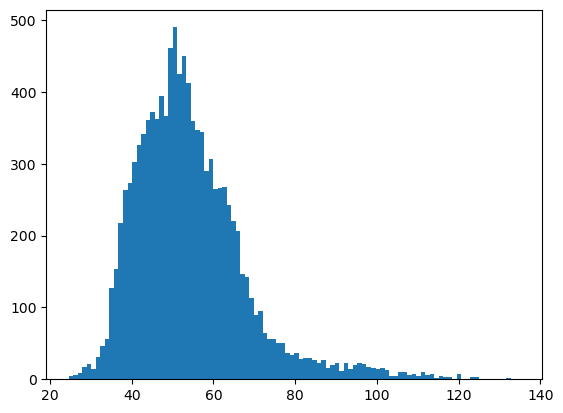

In [ ]:
center = np.zeros(config.latent_dim)

euler_dists = [np.linalg.norm(mean.detach().numpy() - center) for mean, _ in means_logvars]

plt.hist(euler_dists, bins=100)

In [ ]:
sample_groups = config.sample_group.split(',') if config.sample_group != 'all' else ['kick', 'clap', 'hat', 'snare', 'tom', 'cymbal', 'crash', 'ride']

# mfccs = [pad_or_trim(convert_to_mfcc(wave, sr), length=config.pad_or_trim_length) for wave, sr in load_all_waves(sample_groups)]
mfccs_sample_groups = [(pad_or_trim(convert_to_mfcc(wave, sr), length=100), sample_group) for wave, sr, sample_group in load_all_waves(sample_groups, return_sample_groups=True)]

means_and_sample_groups = [(model.encoder(torch.tensor(x).view(1, 1, *x.shape))[0].detach().numpy().squeeze() ,sample_group) for x, sample_group in mfccs_sample_groups]

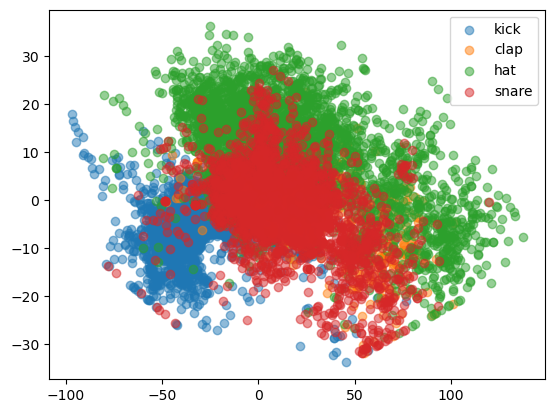

In [ ]:
pca = sklearn.decomposition.PCA(n_components=2)

means = [mean for mean, _ in means_and_sample_groups]

pca.fit(means)

for sample_group in sample_groups:
    plt.scatter(*zip(*pca.transform([mean for mean, group in means_and_sample_groups if group == sample_group])), label=sample_group, alpha=0.5)

plt.legend()
plt.show()

(4045, 3)
(1103, 3)
(2700, 3)
(3060, 3)


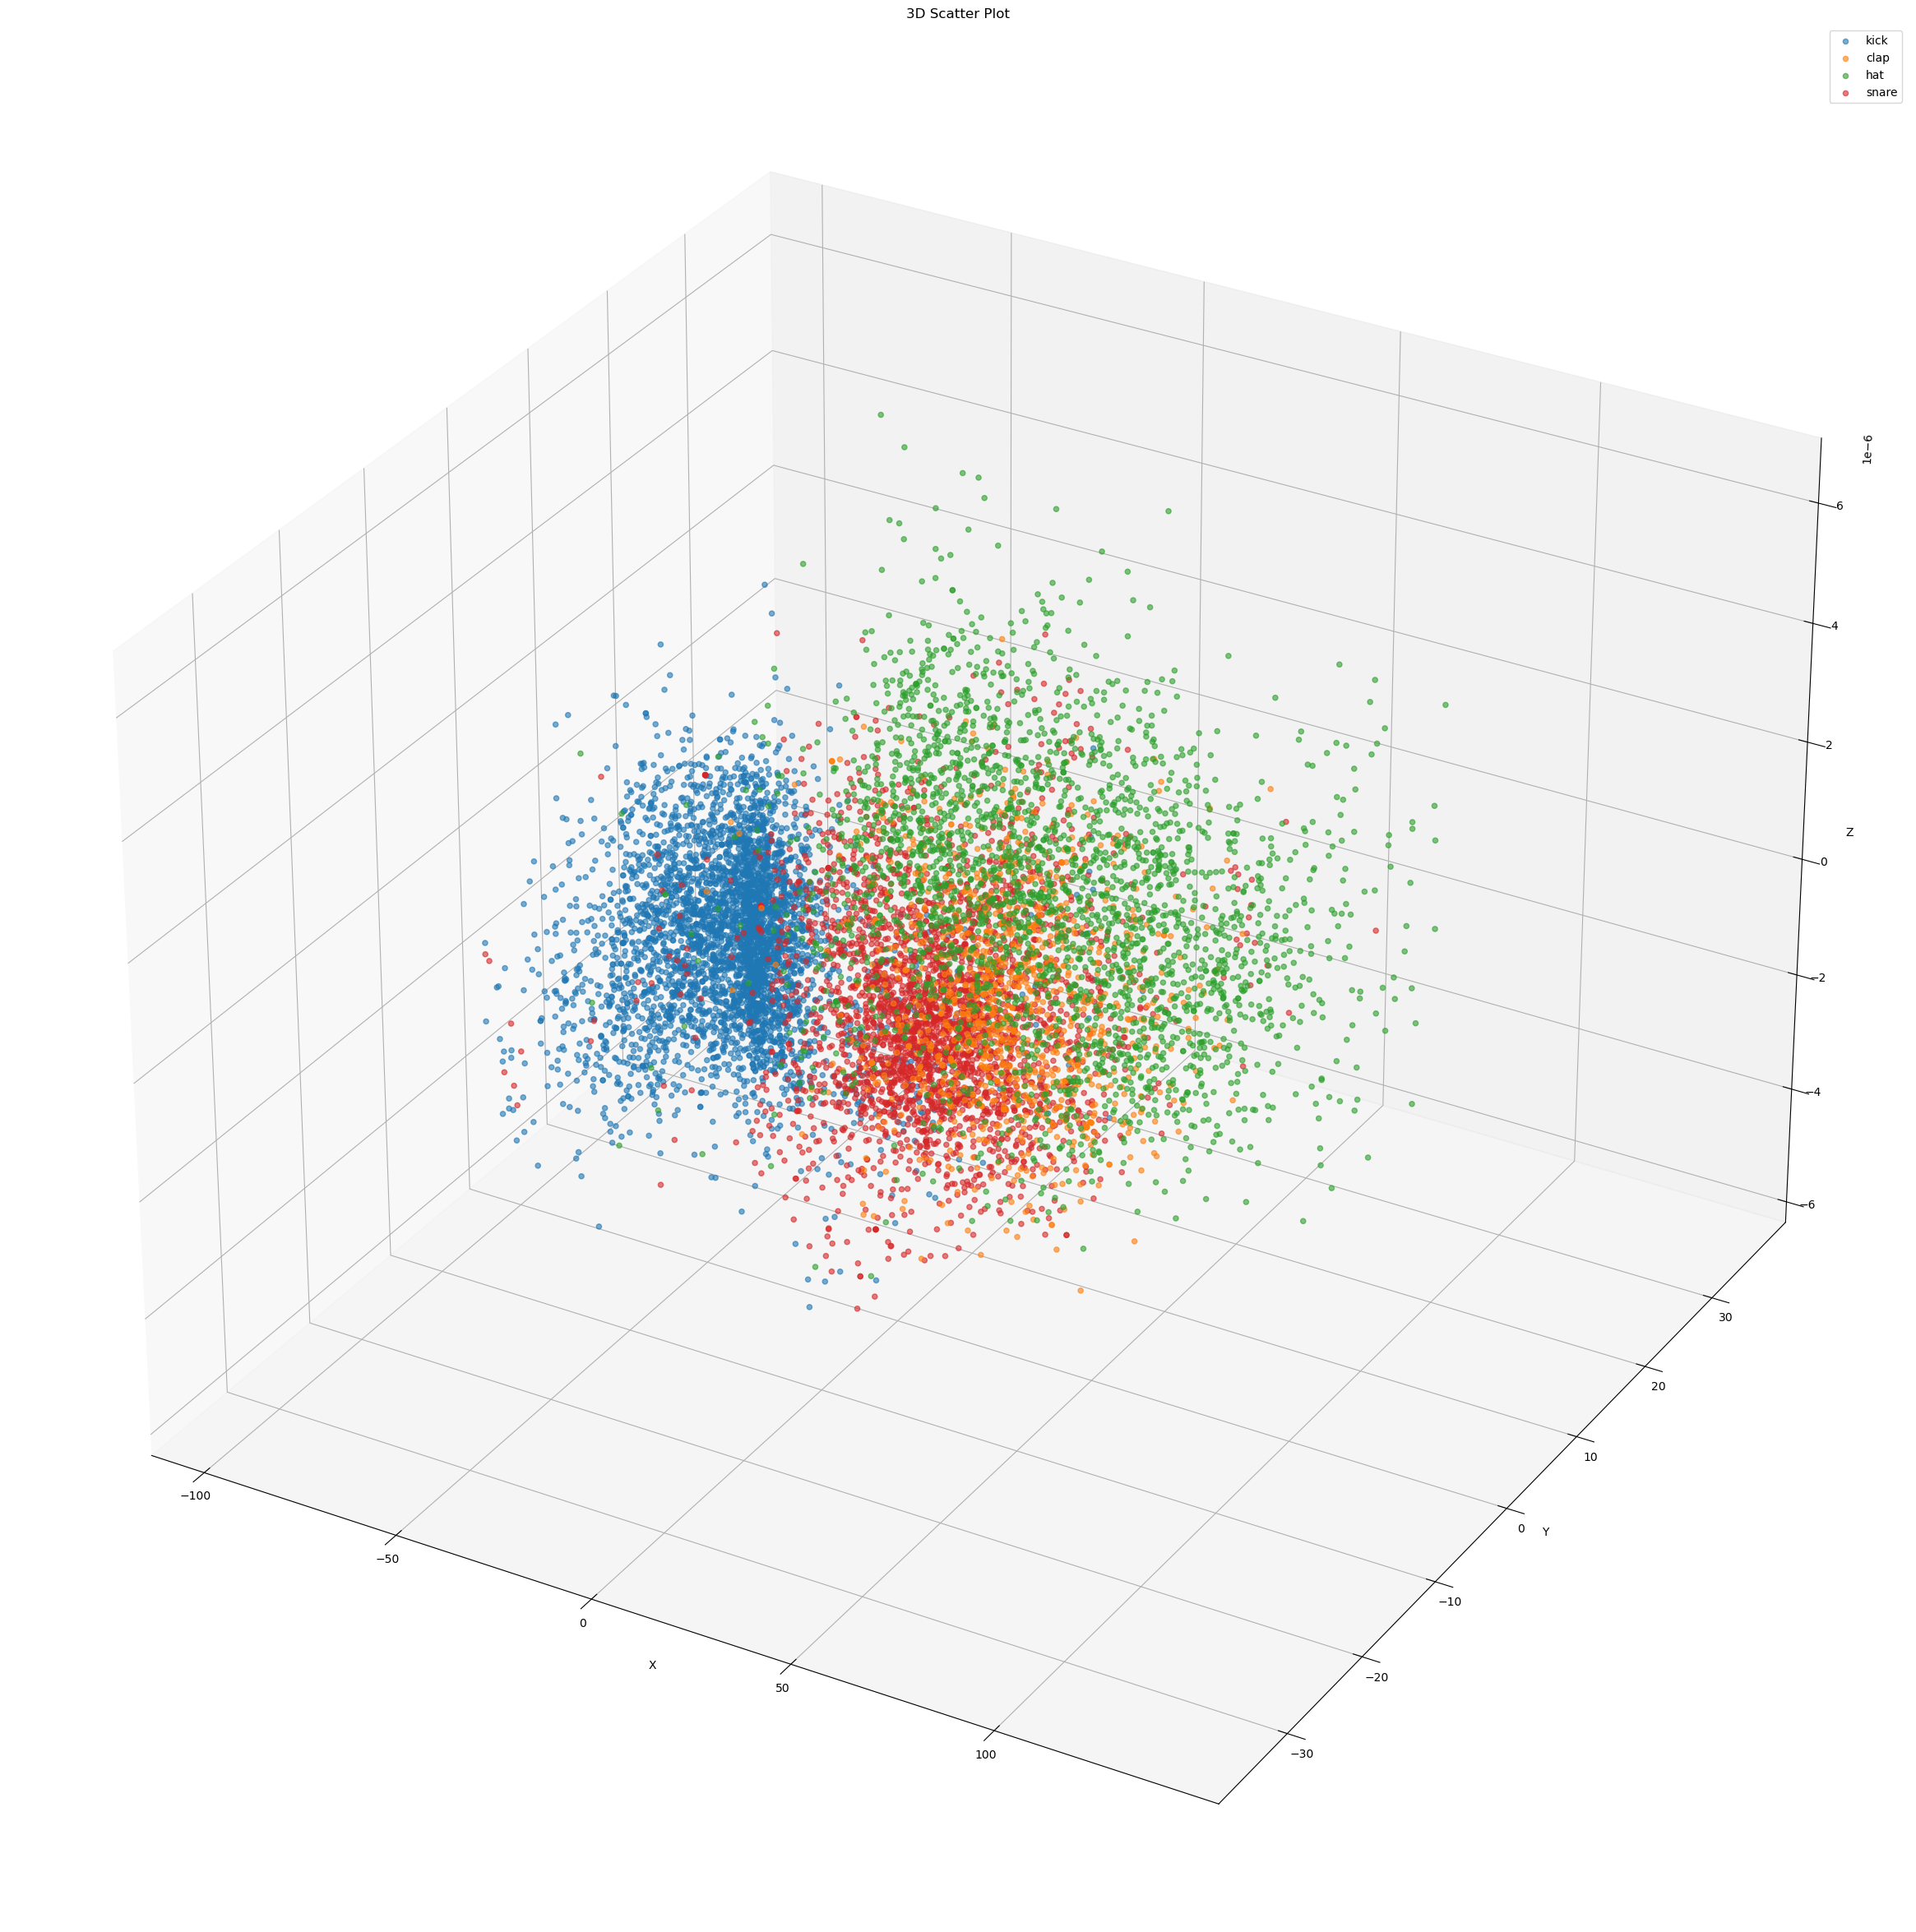

In [ ]:
pca = sklearn.decomposition.PCA(n_components=3)

means = [mean for mean, _ in means_and_sample_groups]

pca.fit(means)


fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot') 


for sample_group in sample_groups:
    transformed = pca.transform([mean for mean, group in means_and_sample_groups if group == sample_group])

    print(transformed.shape)

    x = transformed[:, 0]
    y = transformed[:, 1]
    z = transformed[:, 2]

    ax.scatter(x, y, z, label=sample_group, alpha=0.6)


plt.legend()
plt.show()

In [ ]:
pca = sklearn.decomposition.PCA(n_components=3)

means = [mean for mean, _ in means_and_sample_groups]

pca.fit(means)


trace = []
colors = ['blue', 'red', 'green', 'yellow']

for i, sample_group in enumerate(sample_groups):
    transformed = pca.transform([mean for mean, group in means_and_sample_groups if group == sample_group])

    x = transformed[:, 0]
    y = transformed[:, 1]
    z = transformed[:, 2]

    trace.append(plotly.graph_objs.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers', 
        name=sample_group, 
        marker=dict(size=4, color=colors[i], line=dict(width=0.5, color=colors[i]))))
    
# Combine traces into a figure
fig = plotly.graph_objs.Figure(data=trace)

# Update layout for 3D scene
fig.update_layout(
    title='3D Scatter Plot with Multiple Point Types',
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis'
    )
)

fig.write_html('my_interactive_3d_scatter.html')

### posun zvuku v latent space o alpha nasobok pca vektoru

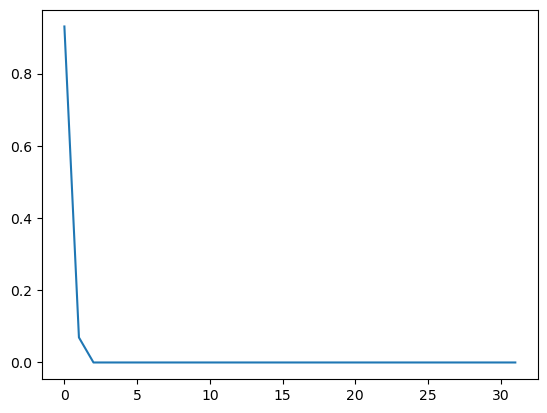

In [ ]:
pca = sklearn.decomposition.PCA()

means = [mean.detach().numpy().squeeze() for mean, _ in means_logvars]

pca.fit(means)

comp = pca.components_
comp.shape

plt.plot(pca.explained_variance_ratio_)

In [ ]:
vector_1 = (comp[0] / np.linalg.norm(comp[0])).astype(np.float32)   
vector_2 = (comp[1] / np.linalg.norm(comp[1])).astype(np.float32)
vector_3 = (comp[2] / np.linalg.norm(comp[2])).astype(np.float32)
vector_4 = (comp[3] / np.linalg.norm(comp[3])).astype(np.float32)

In [ ]:
vector = vector_4

wave, sr = load_random_wave('snare')
x = pad_or_trim(convert_to_mfcc(wave, sr), length=100)

mean, logvar = model.encoder.forward(torch.tensor(x).view(1, 1, *x.shape))

mean = mean.detach().numpy().squeeze()

sd.play(wave, sr); sd.wait()

for alpha in [0,0.1,0.5,1,5,10,50,100, 200, 500]:
    sd.play(convert_to_wave(model.decoder.forward(torch.tensor(mean + alpha * vector).view(1, 1, config.latent_dim)).detach().numpy().reshape(-1, 100), sr), sr)
    print(str(alpha) + '          ', end='\r')
    sd.wait()

c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\llama\anaconda3\envs\bakalarka\Lib\site-packages\librosa\feature\inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


### Corelation Metrics